<a href="https://colab.research.google.com/github/fatemeh-moghaddam/Bachelor-Thesis-Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive

In [ ]:
from __future__ import division, print_function, absolute_import
%tensorflow_version 1.x
import tensorflow as tf
import scipy.io as sio
import numpy as np
from sklearn.utils import shuffle
from google.colab import drive

TensorFlow 1.x selected.


In [ ]:
from glob import glob
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Loading library

In [ ]:
'''firstly we have to install this library'''
!pip install tslearn
from heapq import nsmallest
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, balanced_accuracy_score,recall_score,precision_score, f1_score
from imblearn.metrics import specificity_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

     |████████████████████████████████| 747kB 5.4MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

# Loading data

In [ ]:
subfolders = glob("/content/gdrive/My Drive/project/Arani/*")
subfolders.sort()
print (subfolders)
print (len(subfolders))

['/content/gdrive/My Drive/project/Arani/test=p01', '/content/gdrive/My Drive/project/Arani/test=p02', '/content/gdrive/My Drive/project/Arani/test=p03', '/content/gdrive/My Drive/project/Arani/test=p05', '/content/gdrive/My Drive/project/Arani/test=p06', '/content/gdrive/My Drive/project/Arani/test=p07', '/content/gdrive/My Drive/project/Arani/test=p08', '/content/gdrive/My Drive/project/Arani/test=p09']
8


In [ ]:
#choose which subject be the test one:
n = 1 #test=p02
Train_data1 = sio.loadmat(subfolders[n]+'/data1.mat')['data1']
Train_data = np.zeros((Train_data1.shape[0],9))
Train_data[:,0] = Train_data1[:,0]
for k in range (2,10):
  Train_data[:,k-1] = sio.loadmat(subfolders[n]+'/data'+str(k)+'.mat')['data'+str(k)][:,0]
print(Train_data.shape)
Label_train = sio.loadmat(subfolders[n]+'/label.mat')['label']
print(Label_train.shape)
#loading test data
Test_data1 = sio.loadmat(subfolders[n]+'/Test1.mat')['Test1']
Test_data = np.zeros((Test_data1.shape[0],9))
Test_data[:,0] = Test_data1[:,0]
for k in range (2,10):
  Test_data[:,k-1] = sio.loadmat(subfolders[n]+'/Test'+str(k)+'.mat')['Test'+str(k)][:,0]
print(Test_data.shape)
Label_test = sio.loadmat(subfolders[n]+'/label_test.mat')['labeltest']
print(Label_test.shape)

(198352, 9)
(198352, 1)
(23218, 9)
(23218, 1)


# Windowing

## Windowing of train data

In [ ]:
# windowing
window_length =50#variable
overlap=49       #variable
window_num_train=int(Train_data.shape[0]/window_length)+int((Train_data.shape[0]%window_length+overlap*(int(Train_data.shape[0]/window_length)-1))/(window_length-overlap))
counter_FOG_train = 0   #defines the number of data train that have zero label & should be vanished
index_train = np.zeros([window_num_train,1])
##windowing of train data with overlap
TrainData_windowed = np.zeros([window_num_train, window_length, 9]) #[6162*50*9]
TrainLabel_windowed = np.zeros([window_num_train, 2])

for i in range(window_num_train):
  for k in range (0,9):
    TrainData_windowed[i,0: window_length,k] = Train_data[(i*(window_length-overlap)) : (i*(window_length-overlap)) + window_length, k]
 ##determining the label of each window
  if Label_train[(i*(window_length-overlap)),0]==2: #if first element's label=2,then we already have recognized FOG
    TrainLabel_windowed[i,1] = 0          # [i,0]=1 FOG was happening before, Nothing new happened ,label=0
    TrainLabel_windowed[i,0] = 1
    index_train[i,0] = 1                 #this is for vanish these data with label 0
  else: 
    for j in range(window_length-1): 
      if  Label_train[(i*(window_length-overlap))+1 + j,0]==2:
        TrainLabel_windowed[i,1] = 1         # [i,1]=1 FOG happened
        TrainLabel_windowed[i,0] = 0
        counter_FOG_train = counter_FOG_train+ 1 
        break
      else:
        TrainLabel_windowed[i,1] = 0          # [i,0]=1 Nothing happened
        TrainLabel_windowed[i,0] = 1

## Windowing of test data

In [ ]:
window_num_test=int(Test_data.shape[0]/window_length)+int((Test_data.shape[0]%window_length+overlap*(int(Test_data.shape[0]/window_length)-1))/(window_length-overlap))
counter_FOG_test = 0    #defines the number of data test that have zero label & should be vanished
index_test = np.zeros([window_num_test,1])
  ##windowing of test data
TestData_windowed = np.zeros([window_num_test, window_length, 9]) #[6162*50*9]
TestLabel_windowed = np.zeros([window_num_test, 2])
for i in range(window_num_test):
  for k in range (0,9):
    TestData_windowed[i,0: window_length,k] = Test_data[(i*(window_length-overlap)) : (i*(window_length-overlap)) + window_length, k]
 ##determining the label of each window
  if Label_test[(i*(window_length-overlap)),0]==2:
    TestLabel_windowed[i,1] = 0          # [i,0]=1 FOG was happening before, Nothing new happened
    TestLabel_windowed[i,0] = 1
    index_test[i,0] = 1                 #this is for vanish some data with label 0
  else: 
    for j in range(window_length-1): 
      if  Label_test[(i*(window_length-overlap))+1 + j,0]==2:
        TestLabel_windowed[i,1] = 1         # [i,1]=1 FOG happened
        TestLabel_windowed[i,0] = 0
        counter_FOG_test = counter_FOG_test+ 1 
        break
      else:
        TestLabel_windowed[i,1] = 0          # [i,0]=1 Nothing happened
        TestLabel_windowed[i,0] = 1

# Normalization

In [ ]:
#VERSION ZAHRA:
#when we use train_data maximums for test_data normalizations
##Train Data
maximum_train = np.zeros([9,1])
for k in range (0,9):
  maximum_train[k,0] = np.max(TrainData_windowed[:,:,k])

minimum_train = np.zeros([9,1])
for k in range (0,9):
  minimum_train[k,0] = np.min(TrainData_windowed[:,:,k])

for k in range (0,9):
  for i in range(window_num_train):  # counter_FOG_train*2 is the number of train data
    for j in range(window_length):
      TrainData_windowed[i,j,k] = (TrainData_windowed[i,j,k] - minimum_train[k,0])/(maximum_train[k,0]- minimum_train[k,0])
##Test Data

for k in range (0,9):
  for i in range(window_num_test): 
    for j in range(window_length):
      TestData_windowed[i,j,k] = (TrainData_windowed[i,j,k] - minimum_train[k,0])/(maximum_train[k,0]- minimum_train[k,0])


In [ ]:
#when we use each maximums for their own normalization
##Train Data
maximum_train = np.zeros([9,1])
for k in range (0,9):
  maximum_train[k,0] = np.max(TrainData_windowed[:,:,k])

minimum_train = np.zeros([9,1])
for k in range (0,9):
  minimum_train[k,0] = np.min(TrainData_windowed[:,:,k])

for k in range (0,9):
  for i in range(window_num_train):  # counter_FOG_train*2 is the number of train data
    for j in range(window_length):
      TrainData_windowed[i,j,k] = (TrainData_windowed[i,j,k] - minimum_train[k,0])/(maximum_train[k,0]- minimum_train[k,0])
##Test Data
maximum_test = np.zeros([9,1])
for k in range (0,9):
  maximum_test[k,0] = np.max(TestData_windowed[:,:,k])

minimum_test = np.zeros([9,1])
for k in range (0,9):
  minimum_test[k,0] = np.min(TestData_windowed[:,:,k])

for k in range (0,9):
  for i in range(window_num_test): 
    for j in range(window_length):
      TestData_windowed[i,j,k] = (TestData_windowed[i,j,k] - minimum_test[k,0])/(maximum_test[k,0]- minimum_test[k,0])


# Vanishing

In [ ]:
counter_index_train = 0 #number of train data with zero label or in the middle of FOG & will be vanished
counter_index_test = 0 #number of test data with zero label or in the middle of FOG & will be vanished
for i in range(window_num_train):
  if index_train[i,0] == 0:
    counter_index_train = counter_index_train + 1
print('number of vanished:',window_num_train-counter_index_train)
for i in range(window_num_test):
  if index_test[i,0] == 0:
    counter_index_test = counter_index_test + 1
    
TrainData_windowed_v = np.zeros([counter_index_train,window_length,9])
TrainLabel_windowed_v = np.zeros([counter_index_train,2]) 

TestData_windowed_v = np.zeros([counter_index_test,window_length,9])
TestLabel_windowed_v = np.zeros([counter_index_test,2]) 

counter = -1*np.ones([9,2])
for k in range (0,9):
  for j in range(window_num_train):
    if index_train[j,0] == 0:
      counter[k,0] = counter[k,0] + 1
      TrainData_windowed_v[int(counter[k,0]),:,k] = TrainData_windowed[j,:,k]
      TrainLabel_windowed_v[int(counter[k,0]),:] = TrainLabel_windowed[j,:]
  for j in range(window_num_test):
    if index_test[j,0] == 0:
      counter[k,1] = counter[k,1] + 1
      TestData_windowed_v[int(counter[k,1]),:,k] = TestData_windowed[j,:,k]
      TestLabel_windowed_v[int(counter[k,1]),:] = TestLabel_windowed[j,:]
window_num_train_v = TrainLabel_windowed_v.shape[0]
window_num_test_v = TestLabel_windowed_v.shape[0]   

number of vanished: 99176


# Balancing

## Separate data class matrices

In [ ]:
TrainLabel_windowed0= np.zeros([TrainLabel_windowed_v.shape[0]-counter_FOG_train,2])    # matrix of zeros label (window_num_train-number of ones label)*2
TrainData_windowed0= np.zeros([TrainLabel_windowed_v.shape[0]-counter_FOG_train,window_length,9])     # matrix of data with zero label (window_num_train-number of ones label)*window_length

TrainLabel_windowed1 = np.zeros([counter_FOG_train,2])     # matrix of ones label  counter_train*2
TrainData_windowed1 = np.zeros([counter_FOG_train,window_length,9])     # matrix of data1 with one label counter_train*window_length

counter = -1*np.ones([9,2])
print( TrainLabel_windowed0.shape)
print( TrainLabel_windowed1.shape)
print( TrainData_windowed0.shape)
print( TrainData_windowed1.shape)
for k in range (0,9):
  for i in range(window_num_train_v):
    if TrainLabel_windowed_v[i,0] == 1:
      counter[k,0] = counter[k,0] + 1
      TrainLabel_windowed0[int(counter[k,0]),:] = TrainLabel_windowed_v[i,:]
      TrainData_windowed0[int(counter[k,0]),:,k] = TrainData_windowed_v[i,:,k]
    elif TrainLabel_windowed_v[i,1] == 1:
      counter[k,1] = counter[k,1] + 1
      TrainLabel_windowed1[int(counter[k,1]),:] = TrainLabel_windowed_v[i,:]
      TrainData_windowed1[int(counter[k,1]),:,k] = TrainData_windowed_v[i,:,k]
  num_zero_label = int(counter[k,0])+ 1
  num_one_label = int(counter[k,1])+ 1
print('# of zero labels:',num_zero_label)
print('# of one labels:',num_one_label)

(89521, 2)
(9606, 2)
(89521, 50, 9)
(9606, 50, 9)
# of zero labels: 89521
# of one labels: 9606


##**plot** seperated data

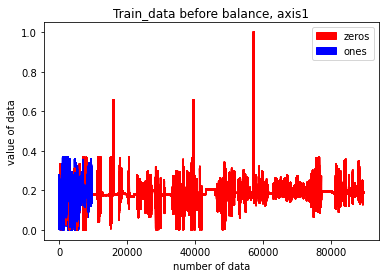

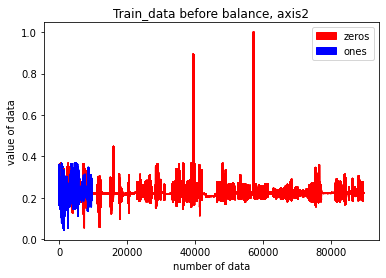

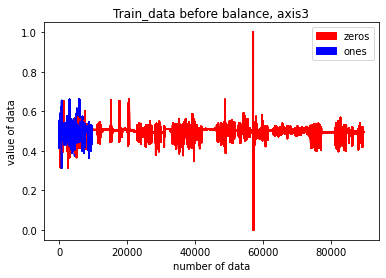

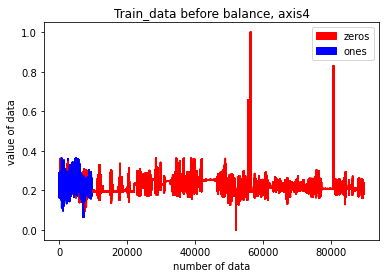

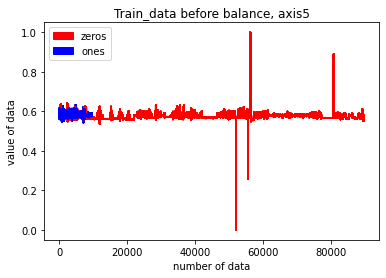

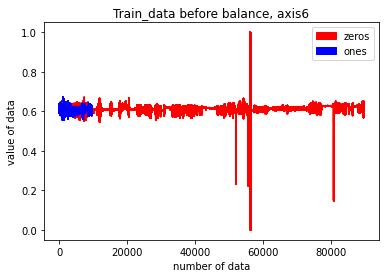

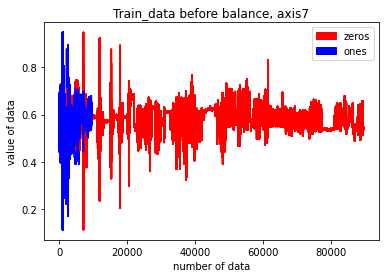

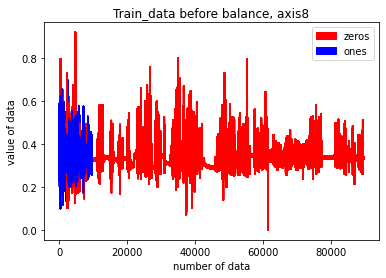

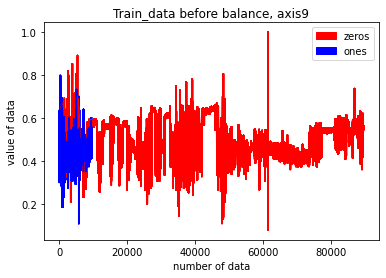

In [ ]:
import matplotlib.patches as mpatches
datafolders = glob("/content/gdrive/My Drive/project/processed data/*")
datafolders.sort()
for k in range(9):       
  plt.figure(k+1)
  plt.title('Train_data before balance, axis'+str(k+1))
  plt.xlabel('number of data')
  plt.ylabel('value of data')
  for j in range(window_length):
    # x0 = np.linspace(j*window_length,(j+1)*(window_length-1),num_zero_label)
    # x1 = np.linspace(j*window_length,(j+1)*(window_length-1),num_one_label)
    plot0 = plt.plot(TrainData_windowed0[:,j,k],'r') 
    plot1 = plt.plot(TrainData_windowed1[:,j,k],'b')
  red_patch = mpatches.Patch(color='red', label='zeros')
  blue_patch = mpatches.Patch(color='blue', label='ones')
  plt.legend(handles=[red_patch,blue_patch])
  # plt.savefig(datafolders[n]+'/data'+str(k+1)+'.png')
plt.show()

##**OPT**:Choose randomly to delete_instead of clustering

In [ ]:
random_index = np.random.randint(0, high=num_zero_label, size=(num_one_label,1), dtype='int')
print(random_index.shape)
TrainData_windowed0_b = np.zeros([num_one_label,50,9])
TrainLabel_windowed0_b = np.zeros([num_one_label,2])
for i in range (0,num_one_label):
  TrainData_windowed0_b[i,:,:] = TrainData_windowed0[random_index[i,0],:,:]
  TrainLabel_windowed0_b[i,:] = TrainLabel_windowed0[random_index[i,0],:]
print(TrainData_windowed0_b.shape)

(9692, 1)
(9692, 50, 9)


## Clustering zero class

In [ ]:
seed = 0
np.random.seed(seed)
km = TimeSeriesKMeans(n_clusters = 10, metric="euclidean", max_iter=5, random_state=seed)       
y_pred = km.fit_predict(TrainData_windowed0)
#X_train shape: (25490, 64, 1) and you have to prepare your data in this format
# for i in range(2,10): # you can do it for only one number instead of using "for"
    #you can use metric="softdtw" but remember dtw metric needs more time to prepare.
#     km = TimeSeriesKMeans(n_clusters = 10, metric="euclidean", max_iter=5,max_iter_barycenter=5,metric_params={"gamma": .5}, random_state=seed) 
    # the silhouette_score number eTestuate your best number for clustering plz check it on internet!
#     y_pred = km.fit_predict(X_train)
#     print(i,':',silhouette_score(X_train, y_pred, metric="softdtw"))

##Constitute clusters

In [ ]:
n_clusters = 10
# n_clusters = 9

county= np.zeros([n_clusters,1])

for k in range (0,n_clusters):
  for i in range(TrainData_windowed0.shape[0]):
    if km.labels_[i]==k:  #demonstrates the cluster number i
      county[k,0]=county[k,0]+1
  # print('# of cluster'+str(k+1)+':',county[k,0])  
num_zero_label_c = np.sum(county[:,0])
counter_c = -1*np.ones([n_clusters,1])

sample_per_cluster = int(num_one_label/n_clusters) #for defining the number of data that 
# we will take from each cluster

cluster = [] #make a list of clusters, which each are an array
cluster_label = []
for i in range (0,n_clusters):
  cluster.append(np.zeros([int(county[i,0]),50,9]))
  cluster_label.append(np.zeros([int(county[i,0]),2]))

for i in range(TrainData_windowed0.shape[0]):
  for k in range(0,n_clusters):
    if km.labels_[i]==k:
      counter_c[k,0] = counter_c[k,0] + 1
      cluster[k][int(counter_c[k,0]),:,:] = TrainData_windowed0[i,:,:]
      cluster_label[k][int(counter_c[k,0]),:] = TrainLabel_windowed0[i,:]
  # print('shape of cluster'+str(k+1)+':',cluster[k].shape)
  # print('shape of label cluster'+str(k+1)+':',cluster_label[k].shape)
print('# of sample per cluster:',sample_per_cluster)
print('# of zero labels:',num_zero_label)
print('#sum of zero c_members:',num_zero_label_c)
print('# difference:',num_zero_label-num_zero_label_c)
print('# of one labels:',num_one_label)

# of sample per cluster: 960
# of zero labels: 89521
#sum of zero c_members: 89521.0
# difference: 0.0
# of one labels: 9606
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


##**OPT:**Choose randomly to balance

In [ ]:
minclusters = nsmallest(2, enumerate(county), key=lambda x: x[1])
min_index = int(minclusters[0][0])
min_member = int(minclusters[0][1])
print('Smallest: cluster'+str(minclusters[0][0])+', #'+ str(minclusters[0][1]))
print('Second mallest: cluster'+str(minclusters[1][0])+',#'+ str(minclusters[1][1]))
extra_num = int((int(sample_per_cluster - min_member)*n_clusters)/(n_clusters-1))
num_zero_label_b = extra_num*(n_clusters-1) + min_member*n_clusters
print('# of balanced zero labels:',num_zero_label_b)
random = []
for i in range (0,n_clusters):
  if i==min_index:
    random.append(np.random.choice(int(county[i]), min_member, replace=False))
  else:
    random.append(np.random.choice(int(county[i]), min_member + extra_num, replace=False))
mini_clusters = []
mini_clusters_label = []
for k in range (0,n_clusters):
  if k==min_index:
    mini_clusters.append(np.zeros([min_member, 50, 9]))
    mini_clusters_label.append(np.zeros([min_member, 2]))
    for i in range (min_member):
      mini_clusters[k][i,:,:] = cluster[k][int(random[k][i]),:,:]
      mini_clusters_label[k][i,:] = cluster_label[k][int(random[k][i]),:]
  else:
    mini_clusters.append(np.zeros([min_member + extra_num, 50, 9]))
    mini_clusters_label.append(np.zeros([min_member + extra_num, 2]))
    for i in range (min_member + extra_num):
      mini_clusters[k][i,:,:] = cluster[k][int(random[k][i]),:,:]
      mini_clusters_label[k][i,:] = cluster_label[k][int(random[k][i]),:]
TrainData_windowed0_b = np.concatenate([mini_clusters[0],mini_clusters[1],mini_clusters[2],mini_clusters[3],mini_clusters[4],mini_clusters[5],mini_clusters[6],mini_clusters[7],mini_clusters[8]])
TrainLabel_windowed0_b = np.concatenate([mini_clusters_label[0],mini_clusters_label[1],mini_clusters_label[2],mini_clusters_label[3],mini_clusters_label[4],mini_clusters_label[5],mini_clusters_label[6],mini_clusters_label[7],mini_clusters_label[8]])
print(TrainData_windowed0_b.shape)
print(TrainLabel_windowed0_b.shape)

Smallest: cluster5, #[2995.]
Second mallest: cluster2,#[4352.]
# of balanced zero labels: 9603
(9603, 50, 9)
(9603, 2)


##2.choose proportionaly to balance 

In [ ]:
pick_num = np.zeros([n_clusters,1]) 
for i in range (0,n_clusters):
  pick_num[i,0] = int(num_one_label * (county[i,0]/num_zero_label_c)+1)
  # print('from c_num'+str(i+1)+': '+str(pick_num[i,0])+' vs c_num:'+str(county[i,0]))
# temp = np.sum(pick_num[:,0])
# print('num_one_label='+str(num_one_label))
# print('temp='+str(temp))
random = []
for i in range (0,n_clusters):
  random.append(np.random.choice(int(county[i]), int(pick_num[i,0]), replace=False))

mini_clusters = []
mini_clusters_label = []

for k in range (0,n_clusters):
  mini_clusters.append(np.zeros([int(pick_num[k,0]), 50, 9]))
  mini_clusters_label.append(np.zeros([int(pick_num[k,0]), 2]))

  for i in range (0,int(pick_num[k,0])):
    mini_clusters[k][i,:,:] = cluster[k][int(random[k][i]),:,:]
    mini_clusters_label[k][i,:] = cluster_label[k][int(random[k][i]),:]

TrainData_windowed0_b = np.concatenate([mini_clusters[0],mini_clusters[1],mini_clusters[2],mini_clusters[3],mini_clusters[4],mini_clusters[5],mini_clusters[6],mini_clusters[7],mini_clusters[8]])
TrainLabel_windowed0_b = np.concatenate([mini_clusters_label[0],mini_clusters_label[1],mini_clusters_label[2],mini_clusters_label[3],mini_clusters_label[4],mini_clusters_label[5],mini_clusters_label[6],mini_clusters_label[7],mini_clusters_label[8]])
print(TrainData_windowed0_b.shape)
print(TrainLabel_windowed0_b.shape)

(8586, 50, 9)
(8586, 2)


##**plot** after balancing

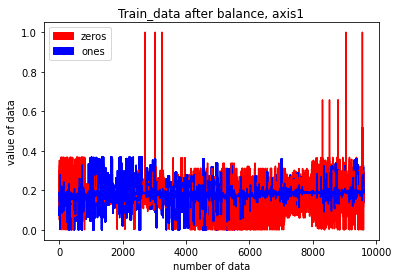

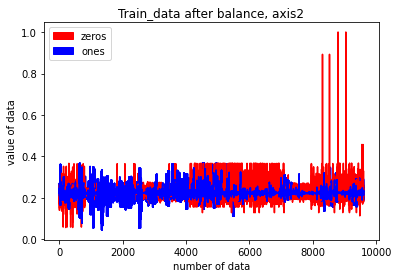

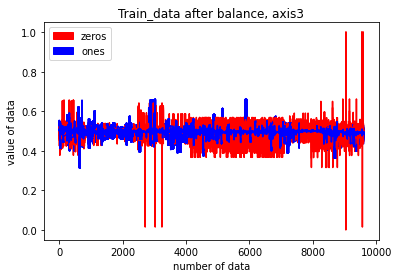

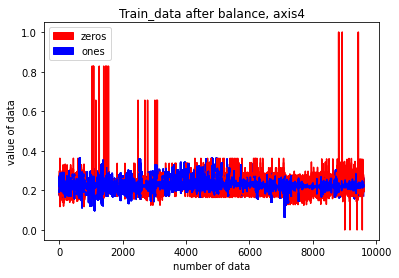

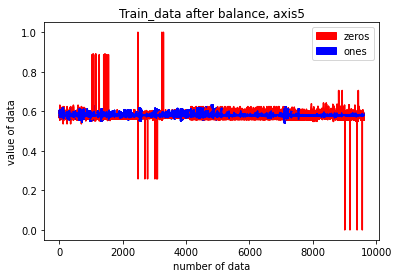

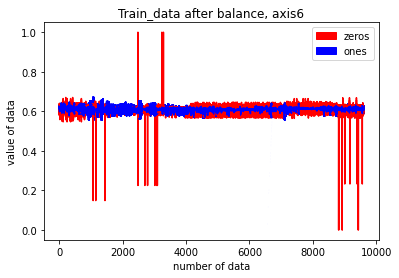

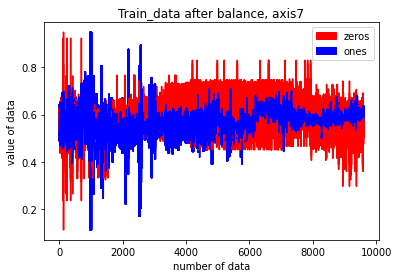

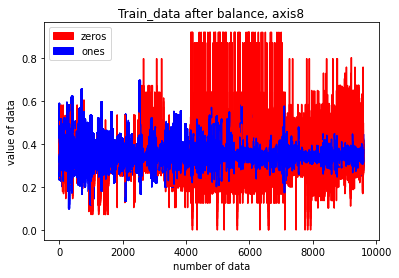

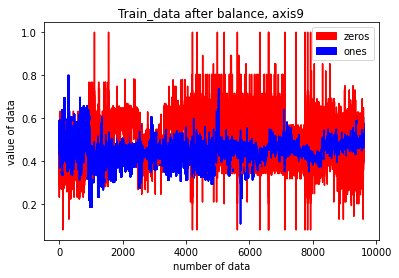

In [ ]:
import matplotlib.patches as mpatches
datafolders = glob("/content/gdrive/My Drive/project/processed data/*")
datafolders.sort()
for k in range(9):       
  plt.figure(k+1)
  plt.title('Train_data after balance, axis'+str(k+1))
  plt.xlabel('number of data')
  plt.ylabel('value of data')
  for j in range(window_length):
    # x0 = np.linspace(j*window_length,(j+1)*(window_length-1),num_zero_label)
    # x1 = np.linspace(j*window_length,(j+1)*(window_length-1),num_one_label)
    plot0 = plt.plot(TrainData_windowed0_b[:,j,k],'r') 
    plot1 = plt.plot(TrainData_windowed1[:,j,k],'b')
  red_patch = mpatches.Patch(color='red', label='zeros')
  blue_patch = mpatches.Patch(color='blue', label='ones')
  plt.legend(handles=[red_patch,blue_patch])
  # plt.savefig(datafolders[n]+'/data'+str(k+1)+'.png')
plt.show()

##Concatenate balanced data

In [ ]:
# print(Data0_train_window1.shape)
TrainData_windowed_b = np.concatenate([TrainData_windowed0_b,TrainData_windowed1])
print(TrainData_windowed_b.shape)
# indices = np.zeros([num_zero_label - num_zero_label_b, 1])
# for i in range (0,num_zero_label - num_zero_label_b):
#   indices[i] = i
# TrainLabel_windowed0_b = np.delete(TrainLabel_windowed0, indices, 0) 
# print(TrainLabel_windowed0_b.shape)
TrainLabel_windowed_b = np.concatenate([TrainLabel_windowed0_b,TrainLabel_windowed1])
print(TrainLabel_windowed_b.shape)

(18192, 50, 9)
(18192, 2)


# Shuffle

In [ ]:
Train_data, Train_label = shuffle(TrainData_windowed_b, TrainLabel_windowed_b)
Test_data, Test_label = TestData_windowed_v, TestLabel_windowed_v
print(Train_data.shape)
print(Train_label.shape)

(18192, 50, 9)
(18192, 2)


#Save preprocessed data

In [ ]:
datafolders = glob("/content/gdrive/My Drive/project/processed data/*")
datafolders.sort()
print(datafolders)
train_dict = dict(data=Train_data, label=Train_label)
test_dict = dict(data=Test_data, label=Test_label)
#test=p01 , n=0
sio.savemat(datafolders[n]+'/without_clustering'+'/train'+str(n+1)+'.mat', train_dict) 
sio.savemat(datafolders[n]+'/without_clustering'+'/test'+str(n+1)+'.mat', test_dict) 

['/content/gdrive/My Drive/project/processed data/test=p01', '/content/gdrive/My Drive/project/processed data/test=p02', '/content/gdrive/My Drive/project/processed data/test=p03', '/content/gdrive/My Drive/project/processed data/test=p05', '/content/gdrive/My Drive/project/processed data/test=p06', '/content/gdrive/My Drive/project/processed data/test=p07', '/content/gdrive/My Drive/project/processed data/test=p08', '/content/gdrive/My Drive/project/processed data/test=p09']


# Network

In [ ]:
# Training Parameters
learning_rate = 0.001
num_epochs = 10
batch_size = 50
# log_interTest = 10

#Number of Iterations
train_iterations = int(Train_data.shape[0]/batch_size)
# train_iterations = 128
Test_iterations = int(Test_data.shape[0]/batch_size)
# Test_iterations = 128
# test_iterations = int(test_data1.shape[0]/batch_size)
log_interTest = train_iterations

# Networks Parameters
num_input =50  # FOG data input (signal shape: 9xnum_input sample)
num_classes = 2  # FOG total classes (FOG happening or not)

# Construct model
# tf Graph input
# FOG data input is a 9-D vector of num_input features (num_input sample in each Input signal)
# input_shape = [None, 50, 9, 1]
# output_shape = [None, 50, 9, 32]
input_signals = tf.placeholder(tf.float32, [None, num_input, 9, 1])
labels         = tf.placeholder(tf.float32, [None, num_classes])          #num_classes
# dropout (keep probability)
keep_prob = tf.placeholder(tf.float32)

# Reshape to match picture format [Height x Width x Channel]
# Tensor input become 4-D:
# [Batch Size, Height, Width, Channel]

# Convolution Layer



conv1 = tf.layers.conv2d(input_signals, 32, 2,  padding='same', activation=tf.nn.leaky_relu)  
print(conv1.shape)
max_pool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='same' )
print(max_pool1.shape)

conv2 = tf.layers.conv2d(max_pool1, 64, 1, padding='same' , activation=tf.nn.leaky_relu)
print(conv2.shape)
max_pool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='same')
print(max_pool2.shape)

conv3 = tf.layers.conv2d(max_pool2, 128, 1, padding='same' , activation=tf.nn.leaky_relu)
print(conv3.shape)
max_pool3 = tf.layers.max_pooling2d(conv3, 2, 2, padding='same')
print(max_pool3.shape)

conv4 = tf.layers.conv2d(max_pool3, 256, 1, padding='same' , activation=tf.nn.leaky_relu)
print(conv4.shape)
max_pool4 = tf.layers.max_pooling2d(conv4, 2, 2, padding='same')
print(max_pool4.shape)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
(?, 50, 9, 32)
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
(?, 25, 5, 32)
(?, 25, 5, 64)
(?, 13, 3, 64)
(?, 13, 3, 128)
(?, 7, 2, 128)
(?, 7, 2, 256)
(?, 4, 1, 256)


# Concatinate

In [ ]:
max_pooln = max_pool4

# Fully connected layer
# Reshape max_pooln output to fit fully connected layer input
# input_shape = [None, 256*21*9]
# output_shape = [None, 256*21*9]
# print(max_pooln.shape)
fc_input = tf.reshape(max_pooln, [-1,max_pooln.shape[1]*max_pooln.shape[2]*max_pooln.shape[3]])   
print(fc_input.shape)
fc = tf.layers.dense(fc_input, 16, activation=tf.nn.leaky_relu)
# #Apply Dropout
after_dropout = tf.nn.dropout(fc, keep_prob)
# Output, class prediction
logits = tf.layers.dense(after_dropout, num_classes)
print(labels.shape)
print(logits.shape)
prediction = tf.nn.softmax(logits)
print(prediction.shape)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
# sample_weights = tf.reduce_sum(tf.multiply(self.one_hot_labels, class_weights), 1)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# ETestuate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


# Initialize the variables (i.e. assign their default Testue)
init_op = tf.global_variables_initializer()


(?, 1024)
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 2)
(?, 2)
(?, 2)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Training

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
#Start training
loss_mat_Test = np.zeros([num_epochs,1])
balanced_mat_Test = np.zeros([num_epochs,1])
f1_mat_Test = np.zeros([num_epochs,1])
specificity_mat_Test = np.zeros([num_epochs,1])
sensitivity_mat_Test = np.zeros([num_epochs,1])
precision_mat_Test = np.zeros([num_epochs,1])
loss_mat_train = np.zeros([num_epochs,1])
balanced_mat_train = np.zeros([num_epochs,1])
with tf.Session() as sess:

    # Run the initializer
    sess.run(init_op)
   
    for epoch in range(num_epochs):
      
        Label_train_Pred=np.zeros([train_iterations*batch_size])
        # TRAIN
        loss, acc = 0., 0.
        for iteration in range(train_iterations):
            batch_x= np.reshape(Train_data[iteration*batch_size:iteration*batch_size+ batch_size,:,:],(-1,window_length,9,1)) 
            batch_y = Train_label[iteration*batch_size:iteration*batch_size+ batch_size,:]

            _, batch_loss, batch_acc ,batch_train_pre= sess.run([train_op, loss_op, accuracy, prediction], feed_dict={
                input_signals: batch_x, labels: batch_y, keep_prob: 0.8})
            loss += batch_loss
            acc += batch_acc
            Label_train_Pred[iteration*batch_size:iteration*batch_size+ batch_size] = np.argmax(batch_train_pre,1)
            if (iteration+1) % log_interTest == 0:         
              print('epoch %d' % (epoch+1))
#                 print('iteration %d' % (iteration+1))
              loss_mat_train[epoch]=loss/log_interTest
              balanced_mat_train[epoch]=balanced_accuracy_score(np.argmax(Train_label[0:train_iterations*batch_size],1),Label_train_Pred)
              print('train loss = %s, train accuracy = %s' % (loss/log_interTest, acc/log_interTest))
              print(color.BLUE +"train balanced_accuracy_score={}".format(balanced_accuracy_score(np.argmax(Train_label[0:train_iterations*batch_size],1),Label_train_Pred))+ color.END)
              loss, acc = 0, 0

        Label_Test_Pred=np.zeros([Test_iterations*batch_size])
      # Test
        loss, acc = 0., 0.
        for iteration in range(Test_iterations):
            batch_x= np.reshape(Test_data[iteration*batch_size:iteration*batch_size+ batch_size,:,:],(-1,window_length,9,1)) 
            batch_y = Test_label[iteration*batch_size:iteration*batch_size+ batch_size,:]
            batch_loss, batch_acc, batch_Test_pre = sess.run([loss_op, accuracy, prediction], feed_dict={
                input_signals: batch_x, labels: batch_y, keep_prob: 1.})
            loss += batch_loss
            acc += batch_acc
            Label_Test_Pred[iteration*batch_size:iteration*batch_size+ batch_size] = np.argmax(batch_Test_pre,1)
      
        loss_mat_Test[epoch,0]=(loss/Test_iterations)
        balanced_mat_Test[epoch,0]=(balanced_accuracy_score(np.argmax(Test_label[0:Test_iterations*batch_size],1),Label_Test_Pred))
        f1_mat_Test[epoch,0]=f1_score(np.argmax(Test_label[0:Test_iterations*batch_size],1),Label_Test_Pred)
        specificity_mat_Test[epoch,0]=specificity_score(np.argmax(Test_label[0:Test_iterations*batch_size],1),Label_Test_Pred)
        sensitivity_mat_Test[epoch,0]=recall_score(np.argmax(Test_label[0:Test_iterations*batch_size],1),Label_Test_Pred)
        precision_mat_Test[epoch,0]=precision_score(np.argmax(Test_label[0:Test_iterations*batch_size],1),Label_Test_Pred)
        print('Test loss = %s, Test accuracy = %s' % (loss/Test_iterations, acc/Test_iterations))
        print(color.BLUE +"Test balanced_accuracy_score={}".format(balanced_accuracy_score(np.argmax(Test_label[0:Test_iterations*batch_size],1),Label_Test_Pred))+ color.END)
        print("Test sensitivity_score={}".format(recall_score(np.argmax(Test_label[0:Test_iterations*batch_size],1),Label_Test_Pred)))
        print("Test specificity_score={}".format(specificity_score(np.argmax(Test_label[0:Test_iterations*batch_size],1),Label_Test_Pred)))
        print("Test precision_score={}".format(precision_score(np.argmax(Test_label[0:Test_iterations*batch_size],1),Label_Test_Pred)))
        print("Test f1_score={}".format(f1_score(np.argmax(Test_label[0:Test_iterations*batch_size],1),Label_Test_Pred)))
        Label_Test_corr = np.argmax(Test_label,1)
        Label_Test_corr_edit = np.zeros([Label_Test_Pred.shape[0],1])
        print(Label_Test_corr_edit.shape)
        for i in range(Label_Test_Pred.shape[0]):
          Label_Test_corr_edit[i] = Label_Test_corr[i]
        con_mat_Test = tf.math.confusion_matrix(Label_Test_corr_edit,Label_Test_Pred)
        with tf.Session():
          print('Confusion Matrix of Test data: \n\n', tf.Tensor.eval(con_mat_Test,feed_dict=None, session=None))
          print(con_mat_Test) 
    print("Optimization Finished!")



epoch 1
train loss = 0.6773867245876428, train accuracy = 0.5623691483470034
train balanced_accuracy_score=0.542704005000038


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test loss = 0.3853805541218101, Test accuracy = 0.912554112783113
Test balanced_accuracy_score=0.5
Test sensitivity_score=0.0
Test specificity_score=1.0
Test precision_score=0.0
Test f1_score=0.0
(11550, 1)
Confusion Matrix of Test data: 

 [[10540     0]
 [ 1010     0]]
Tensor("confusion_matrix/SparseTensorDenseAdd:0", shape=(2, 2), dtype=int32)
epoch 2
train loss = 0.6056296278622525, train accuracy = 0.6495867803405467
train balanced_accuracy_score=0.6398068828867385
Test loss = 0.6637050457847067, Test accuracy = 0.912554112783113
Test balanced_accuracy_score=0.5
Test sensitivity_score=0.0
Test specificity_score=1.0
Test precision_score=0.0
Test f1_score=0.0
(11550, 1)
Confusion Matrix of Test data: 

 [[10540     0]
 [ 1010     0]]
Tensor("confusion_matrix_1/SparseTensorDenseAdd:0", shape=(2, 2), dtype=int32)
epoch 3
train loss = 0.5615649408873776, train accuracy = 0.696363638665722
train balanced_accuracy_score=0.6898333900456446
Test loss = 0.5375518903329775, Test accuracy = 0

KeyboardInterrupt: ignored

# Plot

# Plot of loss

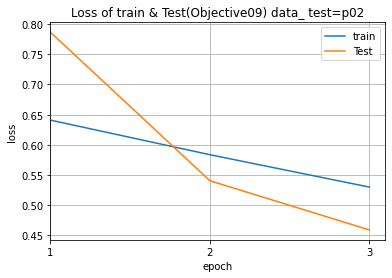

In [ ]:
#loss of train & Test plot
from matplotlib.pyplot import savefig
figure1 = plt.figure()
x=np.arange(1,num_epochs+1)
# x=np.reshape(x,[1,num_epochs])
y=loss_mat_train
# y=np.reshape(y,[1,num_epochs])
plt.plot(x,y ,label="train")
y=loss_mat_Test
# y=np.reshape(y,[1,num_epochs])
plt.plot(x,y, label="Test")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss of train & Test(Objective09) data_ test=p0"+str(n+1))
plt.xticks([i for i in range(num_epochs+1)])
plt.xlim(xmin=1)
plt.grid(True)
plt.legend()
savefig('/content/gdrive/My Drive/project pics')
plt.show()




# Plot of balanced_accuracy

In [ ]:
#balanced_accuracy of train & Test plot
from matplotlib.pyplot import savefig
figure1 = plt.figure()
x=np.arange(1,num_epochs+1)
# x=np.reshape(x,[1,num_epochs])
y=balanced_mat_train*100
# y=np.reshape(y,[1,num_epochs])
plt.plot(x,y ,label="train")
y=balanced_mat_Test*100
# y=np.reshape(y,[1,num_epochs])
plt.plot(x,y, label="Test")
plt.xlabel('epoch')
plt.ylabel('percentage')
plt.title("balanced_accuracy score of train & Test(Objective09) data")
plt.xticks([i for i in range(num_epochs+1)])
plt.xlim(xmin=1)
plt.grid(True)
plt.legend()
savefig('/content/gdrive/My Drive/project pics')
plt.show()

# Test scores

*   for each person as Test data
*   total scores



# for each person as Test data

In [ ]:
balanced_train1 = 0.8171565903870418
balanced_train2 = 0.8192361237785224
balanced_train3 = 0.8142880374762627
balanced_train4 = 0.8157153690425278
balanced_train5 = 0.8172802325791728

loss_train1 = 0.3922238656901497
loss_train2 = 0.39238358781596944
loss_train3 =0.4008009334405263
loss_train4 = 0.3986111358520825
loss_train5 = 0.39585709764270594

balanced_Test1 = 0.8265381473550539
balanced_Test2 = 0.8395956422312678
balanced_Test3 = 0.8144017798036567
balanced_Test4 = 0.823988106511211
balanced_Test5 = 0.8456735684611565

loss_Test1 = 0.3994385499310611
loss_Test2 = 0.4266028103611884
loss_Test3 = 0.4749547936570136
loss_Test4 = 0.3915618652173962
loss_Test5 = 0.3592520615148228

specificity_Test1 =0.8021899547726732
specificity_Test2 = 0.8126636515115448
specificity_Test3 = 0.7257795762913593
specificity_Test4 = 0.8064746488931207
specificity_Test5 =0.8091762252346194

sensitivity_Test1 = 0.8508863399374348
sensitivity_Test2 =0.8665276329509907 
sensitivity_Test3 = 0.9030239833159541
sensitivity_Test4 = 0.8415015641293013
sensitivity_Test5 = 0.8091762252346194

precision_Test1 =0.49544626593806923
precision_Test2 = 0.5135970333745364
precision_Test3 = 0.42913776015857286
precision_Test4 =0.4981481481481482
precision_Test5 = 0.6105428796223447

f1_Test1 = 0.6262471220260936
f1_Test2 = 0.6449359720605355
f1_Test3 = 0.581793752099429
f1_Test4 =0.6258239627762698
f1_Test5 = 0.6959641255605381

TN1 = 3370
TN2 = 3414
TN3 =3049
TN4 = 3388
TN5 = 3706

TP1 = 816
TP2 = 831
TP3 = 866
TP4 = 807
TP5 = 776

FN1 = 143
FN2 = 128
FN3 = 93
FN4 = 152 
FN5 = 183

FP1 = 831
FP2 = 787
FP3 = 1152
FP4 = 813
FP5 = 495

# total scores

In [ ]:

#person 07
a18=np.sqrt(2.751581938214763e-06)
a28=np.sqrt(1.144439926597069e-05)
b18=0.8167352706527057
b28=0.39597532408828673
c18=np.sqrt(0.00012583221548376604)
c28=np.sqrt(0.0015041971109631173)
c38=np.sqrt(0.0010835485430368537)
c48=np.sqrt(0.0009470240224599621)
c58=np.sqrt(0.003402166384768442)
c68=np.sqrt(0.0013614108885214977)
c78=np.sqrt(870.9599999999998)
c88=np.sqrt(43402.240000000005)
c98=np.sqrt(43402.240000000005)
c108=np.sqrt(870.96)
d18=0.4103620161362964
d28=0.8300394488724692
d38=0.85422314911366
d48=0.7912568113406635
d58=0.5093744174483342
d68=0.6349529869045731
d78=819.2
d88=3385.4
d98=815.6
d108=139.8
#person 08
a17=np.sqrt(8.624597813960658e-06)
a27=np.sqrt(2.640445728290521e-05)
b17=0.8321431621972625
b27=0.3731175079669362 
c17=np.sqrt(0.0009450860508175083)
c27=np.sqrt(0.007877894318094688)
c37=np.sqrt(0.0008943518565617703)
c47=np.sqrt(0.00810346274362926)
c57=np.sqrt(0.0048002748090665934)
c67=np.sqrt(0.0010477581605563137)
c77=np.sqrt(3959.3599999999997)
c87=np.sqrt(131180.24)
c97=np.sqrt(112490.96)
c107=np.sqrt(19285.760000000002)
d17=0.4172614955659563
d27=0.5911575792304588
d37=0.22288984263233189
d47=0.9594253158285856
d57=0.28326043568261483
d67=0.22486143031780012
d77=155.8
d87=11619.6
d97=565.8
d107=468.8
#person 09
a11 =np.sqrt( 8.048798740594017e-06)
a21 = np.sqrt(1.6958696776017684e-05)
b11 = 0.873426747946579
b21 = 0.30504865868297826 
c11 = np.sqrt(8.539783526797906e-05)
c21 = np.sqrt(0.002399276832567183)
c31 = np.sqrt(0.0011534179527954917)
c41 = np.sqrt(0.0007641257802293521)
c51 =np.sqrt( 0.001995121553796102)
c61 =np.sqrt( 0.0018251496802332346)
c71 =np.sqrt( 1347.6)
c81 =np.sqrt( 291852.4)
c91 = np.sqrt(291852.4)
c101 = np.sqrt(1347.6)
d11 = 0.33853967567341553
d21 = 0.8342103641194564
d31 = 0.8079819277108434
d41 = 0.8604388005280693
d51 = 0.3332542478951307
d61 = 0.46943128765784703
d71 = 1073.0
d81 = 13687.0
d91 = 2220.0
d101 = 255.0



#person 01
a12=np.sqrt(6.088455454723066e-06)
a22= np.sqrt(1.6019142117901757e-05)
b12= 0.8879291365669074
b22=0.21700274070457506 
c12=np.sqrt(0.0004932425336252504)
c22=np.sqrt(0.00028934445591881407)
c32=np.sqrt(0.0005451954380102243)
c42=np.sqrt(0.003669065422312176)
c52=np.sqrt(0.00024092103669302403)
c62=np.sqrt( 0.0003556271204745192)
c72= np.sqrt(3132.5600000000004)
c82= np.sqrt(17844.159999999996)
c92= np.sqrt(17844.16)
c102=np.sqrt( 3132.5600000000004)
d12= 0.42816037897941694
d22= 0.7798805721459103
d32= 0.764935064935065
d42= 0.7948260793567559
d52= 0.37665139348401316
d62= 0.503769263245134
d72= 706.8
d82= 4547.2
d92=1173.8
d102=217.2

#person 03
a13= np.sqrt(0.00015145613025308496)
a23=np.sqrt(0.00044893036172701135)
b13=0.8519219479698077
b23=0.341287987374241
c13=np.sqrt(8.277094325720898e-05)
c23=np.sqrt(0.0011584430216967233)
c33=np.sqrt(0.0004201435055145134)
c43=np.sqrt(0.0013965661401462842)
c53=np.sqrt(0.0010930157893227)
c63=np.sqrt(0.0002626776238762121)
c73=np.sqrt(6211.76)
c83=np.sqrt(109936.0)
c93=np.sqrt(109936.0)
c103=np.sqrt(6211.759999999999)
d13=0.2959394648521208
d23=0.8372277018936789
d33=0.7796111901375059
d43=0.8948442136498516
d53=0.49553772315693745
d63=0.6040644912081257
d73=1644.2
d83=14475.0
d93=1701.0
d103=464.8

#person02
a14=np.sqrt(1.0747234314592037e-05)
a24=np.sqrt(3.7359772432700734e-05)
b14=0.8180814340933795
b24=0.39787619530793517 
c14=np.sqrt(2.5378006267089207e-05)
c24=np.sqrt(0.0013173684214232368)
c34=np.sqrt(0.0005732620834894987)
c44=np.sqrt(0.0007568359375000009)
c54=np.sqrt(0.00011832579765421513)
c64=np.sqrt(0.00014007761460112036)
c74=np.sqrt(581.04)
c84=np.sqrt(47720.96)
c94=np.sqrt(47720.96)
c104=np.sqrt(581.04)
d14=0.4715180161554944
d24=0.8046609449354181
d34=0.8875
d44=0.7218218898708362
d54=0.21807469531038248
d64=0.34977643738212877
d74=572.4
d84=5265.8
d94=2089.2
d104=67.6

#person 05
a15= np.sqrt(8.526128399941291e-06)
a25=np.sqrt(2.536336979867653e-05)
b15=0.8265886264955051
b25=0.37908765129766275
c15=np.sqrt(2.2528742205208797e-05)
c25=np.sqrt(0.000319999515206678)
c35=np.sqrt(5.946059114853762e-05)
c45=np.sqrt(0.00020029055168478333)
c55=np.sqrt(5.132813386586624e-05)
c65=np.sqrt(3.6956595057668284e-05)
c75=np.sqrt(1978.56)
c85=np.sqrt(43900.8)
c95=np.sqrt(43900.8)
c105=np.sqrt(1978.56)
d15=0.40169459720514816
d25=0.8022738146486162
d35=0.7767101495386572
d45=0.827837479758575
d55=0.34312434661705804
d65=0.4758602629756187
d75=2441.2
d85=22494.0
d95=4678.0
d105=701.8

#person 06
a16=np.sqrt(4.811146939475548e-06)
a26=np.sqrt(1.2258889971333427e-05)
b16=0.8875970258591984
b26=0.2626735119634926 
c16=np.sqrt(0.0003012239008644242)
c26=np.sqrt(0.00312584040740052)
c36=np.sqrt(0.0037662542748000743)
c46=np.sqrt(0.0012348835321808304)
c56=np.sqrt(0.0007730941764137243)
c66=np.sqrt(0.0013999363592536074)
c76=np.sqrt(243.43999999999997)
c86=np.sqrt(235706.96000000002)
c96=np.sqrt(235706.96000000002)
c106=np.sqrt(243.44)
d16=0.5966618699720115
d26=0.7904896363940732
d36=0.8009009009009009
d46=0.7800783718872457
d56=0.1761684822336918
d66=0.2872266431129832
d76=355.6
d86=6171.2
d96=1739.8
d106=88.4



# New code added by Morteza

In [ ]:
"""
Convolutional Neural Network.

Build and train a convolutional neural network with TensorFlow.
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""

from __future__ import division, print_function, absolute_import

import tensorflow as tf
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("data/", one_hot=True)

# Training Parameters
learning_rate = 0.001
num_epochs = 1
batch_size = 100
log_interTest = 10

# Number of Iterations
train_iterations = int(mnist.train.num_examples/batch_size)
Test_iterations = int(mnist.Test.num_examples/batch_size)
test_iterations = int(mnist.test.num_examples/batch_size)

# Network Parameters
num_input = 784  # MNIST data input (img shape: 28*28)
num_classes = 10  # MNIST total classes (0-9 digits)

# Construct model
# tf Graph input
# MNIST data input is a 1-D vector of 784 features (28*28 pixels)
input_images = tf.placeholder(tf.float32, [None, num_input])
labels = tf.placeholder(tf.float32, [None, num_classes])
# dropout (keep probability)
keep_prob = tf.placeholder(tf.float32)

# Reshape to match picture format [Height x Width x Channel]
# Tensor input become 4-D:
# [Batch Size, Height, Width, Channel]
inputs_reshaped = tf.reshape(input_images, shape=[-1, 28, 28, 1])

# Convolution Layer
# input_shape = [None, 28, 28, 1]
# output_shape = [None, 28, 28, 32]
conv1 = tf.layers.conv2d(inputs_reshaped, 32, 5, padding='same')
# Max Pooling (down-sampling)
# input_shape = [None, 28, 28, 32]
# output_shape = [None, 14, 14, 32]
max_pool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='same')

# Convolution Layer
# input_shape = [None, 14, 14, 32]
# output_shape = [None, 14, 14, 64]
conv2 = tf.layers.conv2d(max_pool1, 64, 5, padding='same')
# Max Pooling (down-sampling)
# input_shape = [None, 14, 14, 64]
# output_shape = [None, 7, 7, 64]
max_pool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='same')

# Fully connected layer
# Reshape max_pool2 output to fit fully connected layer input
# input_shape = [None, 7, 7, 64]
# output_shape = [None, 3136]
fc1_input = tf.reshape(max_pool2, [-1, 7*7*64])
fc1 = tf.layers.dense(fc1_input, 1024, activation=tf.nn.relu)
# Apply Dropout
after_dropout = tf.nn.dropout(fc1, keep_prob)

# Output, class prediction
logits = tf.layers.dense(after_dropout, num_classes)

prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# ETestuate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default Testue)
init_op = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init_op)

    for epoch in range(num_epochs):
        # TRAIN
        loss, acc = 0., 0.
        for iteration in range(train_iterations):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop)
            _, batch_loss, batch_acc = sess.run([train_op, loss_op, accuracy], feed_dict={
                input_images: batch_x, labels: batch_y, keep_prob: 0.75})
            loss += batch_loss
            acc += batch_acc
            if (iteration+1) % log_interTest == 0:
                print('iteration %d' % (iteration+1))
                print('train loss = %s, train accuracy = %s' % (loss/log_interTest, acc/log_interTest))
                loss, acc = 0, 0

        # Test
        loss, acc = 0., 0.
        for iteration in range(Test_iterations):
            batch_x, batch_y = mnist.Test.next_batch(batch_size)
            batch_loss, batch_acc = sess.run([loss_op, accuracy], feed_dict={
                input_images: batch_x, labels: batch_y, keep_prob: 1.})
            loss += batch_loss
            acc += batch_acc
        print('Test loss = %s, Test accuracy = %s'
              % (loss/Test_iterations, acc/Test_iterations))

    print("Optimization Finished!")

    # TEST
    loss, acc = 0., 0.
    for iteration in range(test_iterations):
        batch_x, batch_y = mnist.test.next_batch(batch_size)
        batch_loss, batch_acc = sess.run([loss_op, accuracy], feed_dict={
            input_images: batch_x, labels: batch_y, keep_prob: 1.})
        loss += batch_loss
        acc += batch_acc
    print('test loss = %s, test accuracy = %s' % (loss / test_iterations, acc / test_iterations))